In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np 
import pandas as pd 
import cv2
import os 
import matplotlib.pyplot as plt

In [3]:
labels=os.listdir('/kaggle/input/drowsiness-dataset/train')
print(labels)

['Closed', 'Open', 'yawn', 'no_yawn']


<h2>Visluze data

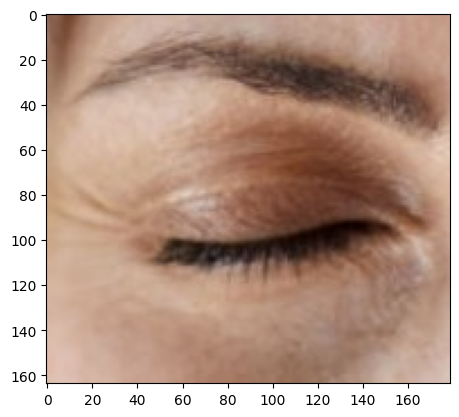

In [4]:
plt.imshow(plt.imread('/kaggle/input/drowsiness-dataset/train/Closed/_102.jpg'))

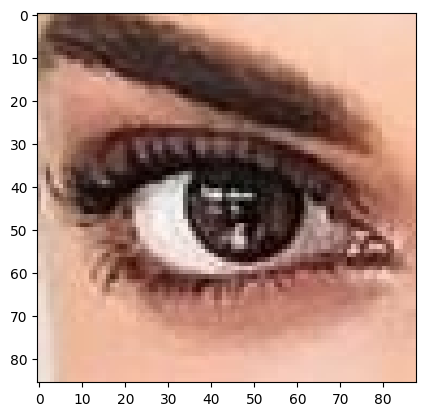

In [5]:
plt.imshow(plt.imread('/kaggle/input/drowsiness-dataset/train/Open/_1.jpg'))

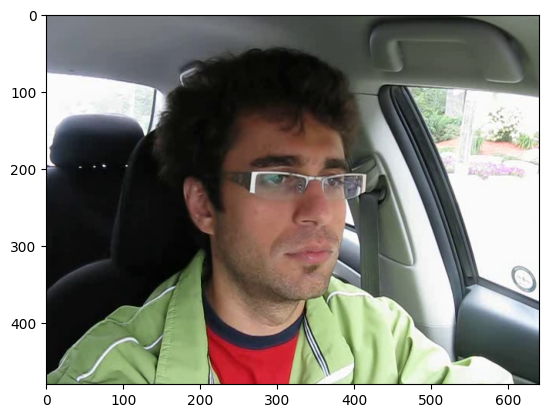

In [6]:
plt.imshow(plt.imread('/kaggle/input/drowsiness-dataset/train/no_yawn/1006.jpg'))

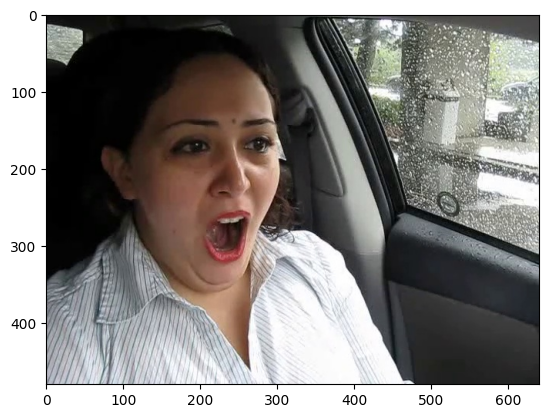

In [7]:
plt.imshow(plt.imread('/kaggle/input/drowsiness-dataset/train/yawn/108.jpg'))

<h2>classifer of yawn or nonyawn

In [8]:
def face_for_yawn(direc="/kaggle/input/drowsiness-dataset/train", face_cas_path="/kaggle/input/facedetection/haarcascade_frontalface_default.xml"):
    yaw_no = []
    categories = ["yawn", "no_yawn"]
    face_cascade = cv2.CascadeClassifier(face_cas_path)
    for class_num1, category in enumerate(categories):
        path_link = os.path.join(direc, category)
        print(class_num1)
        yaw_no.extend(
            [
                [cv2.resize(img[y:y+h, x:x+w], (145, 145)), class_num1]
                for image in os.listdir(path_link)
                if (img := cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)) is not None
                for (x, y, w, h) in face_cascade.detectMultiScale(img, 1.3, 5)
            ]
        )
    return yaw_no

yawn_no_yawn = face_for_yawn()

0
1


<h2>classifer of open or Close

In [9]:
def open_close(dir_path="/kaggle/input/drowsiness-dataset/train", face_cas="/kaggle/input/facedetection/haarcascade_frontalface_default.xml", eye_cas="/kaggle/input/facedetection/haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    face_cascade = cv2.CascadeClassifier(face_cas)
    for class_num, label in enumerate(labels, start=2):
        path = os.path.join(dir_path, label)
        print(class_num)
        data.extend(
            [
                [cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)), class_num]
                for img in os.listdir(path)
                if (img_array := cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)) is not None
            ]
        )
    return data
open_close_data = open_close()

2
3


In [10]:
data_train=open_close()

2
3


<h1>convert data to array 

In [11]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = open_close()
    yaw_no.extend(data)
    return yaw_no

In [12]:
n_data=append_data()

0
1
2
3


<h2>sperate data

In [13]:
X = []
y = []
for feature, label in n_data:
    X.append(feature)
    y.append(label)
X = np.array(X)
y = np.array(y)

In [14]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1925, 145, 145, 3)
Shape of y: (1925,)


<h2>Leabel Encoder 
 <h5> 

In [15]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h1>Train Test Split

In [16]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=.3)

<h1>Data Augmentation

In [17]:
from keras.preprocessing.image import ImageDataGenerator

In [18]:
tr_gen = ImageDataGenerator(
    rescale=1/22,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
 #traing 
Ts_gen=ImageDataGenerator(rescale=1/22) #test
train_gen=tr_gen.flow(np.array(X_train), y_train, shuffle=False)
test_gen = Ts_gen.flow(np.array(X_test), y_test, shuffle=False)


In [19]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

<h1>Creating Model for Conv2D

In [20]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [24]:
model=Sequential()
model.add(Conv2D(256,(3,3),activation="relu",input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 71, 71, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 16, 16, 64)       

In [25]:
def callback():
    cb = []
    checkpoint = ModelCheckpoint('drawsiness.h5', monitor='val_loss', save_best_only=True, verbose=1)
    cb.append(checkpoint)
    es = EarlyStopping(monitor = 'val_loss', patience=10, min_delta=0.0001, verbose=1)
    cb.append(es)
    return cb
cb=callback()

In [39]:
history =model.fit(train_gen , epochs=10 ,validation_data=test_gen,callbacks=cb)

Epoch 1/10
43/43 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9480
Epoch 1: val_loss did not improve from 0.08726
43/43 [==============================] - 7s 167ms/step - loss: 0.1456 - accuracy: 0.9480 - val_loss: 0.1119 - val_accuracy: 0.9654
Epoch 2/10
43/43 [==============================] - ETA: 0s - loss: 0.1227 - accuracy: 0.9510
Epoch 2: val_loss did not improve from 0.08726
43/43 [==============================] - 7s 161ms/step - loss: 0.1227 - accuracy: 0.9510 - val_loss: 0.1084 - val_accuracy: 0.9671
Epoch 3/10
43/43 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9525
Epoch 3: val_loss did not improve from 0.08726
43/43 [==============================] - 7s 164ms/step - loss: 0.1183 - accuracy: 0.9525 - val_loss: 0.1036 - val_accuracy: 0.9654
Epoch 4/10
42/43 [============================>.] - ETA: 0s - loss: 0.1163 - accuracy: 0.9576
Epoch 4: val_loss did not improve from 0.08726
43/43 [==============================] - 7s